In [4]:
import pickle

bundle_path = "../../Results/Pickle_Bundles/logreg_bundle.pkl"

with open(bundle_path, "rb") as f:
    logreg_bundle = pickle.load(f)

print("Bundle keys:", logreg_bundle.keys())

Bundle keys: dict_keys(['model_name', 'y_test', 'y_pred', 'y_proba', 'confusion_matrix', 'accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'log_loss', 'roc_auc_ovr', 'params', 'coef', 'intercept', 'lr_feature_names', 'feature_names', 'X_test_sample', 'best_lr_model'])


### Plot 1: Confusion Matrix

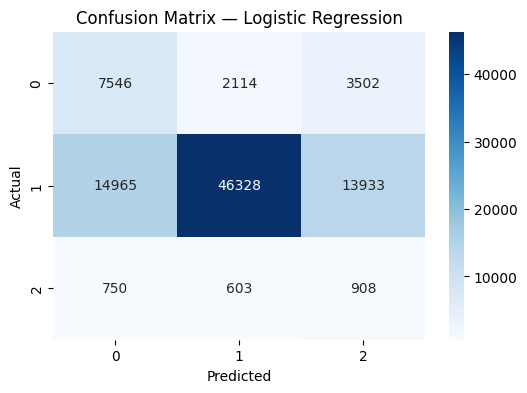

In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load from bundle
y_test = logreg_bundle["y_test"]
y_pred = logreg_bundle["y_pred"]

# Build confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix — Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.savefig("../../Results/Visualizations/Final_visualizations/LR_Confusion_Matrix_plot.png", dpi=300, bbox_inches="tight")
plt.show()

Interpretation:
The confusion matrix shows that the model heavily favors predicting Class 1, correctly identifying a large portion of those cases while also misclassifying many samples from Classes 0 and 2 into Class 1.
Class 0 predictions are moderately accurate, but there’s still substantial spillover into neighboring classes.
Class 2 has the weakest performance overall, with low counts across the diagonal, indicating that the model struggles to recognize this class.
Taken together, the matrix makes it clear that Logistic Regression is biased toward the majority class and has difficulty separating the minority classes.

### Plot 2: ROC Curve

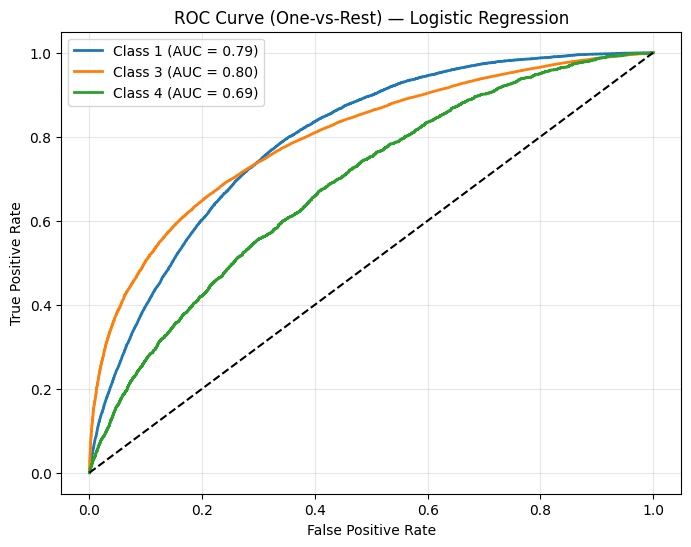

In [6]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

y_test = logreg_bundle["y_test"]
y_proba = logreg_bundle["y_proba"]

classes = np.unique(y_test)
y_bin = label_binarize(y_test, classes=classes)

plt.figure(figsize=(8,6))

for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {cls} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest) — Logistic Regression")
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("../../Results/Visualizations/Final_visualizations/LR_ROC_curve_plot.png", dpi=300, bbox_inches="tight")
plt.show()


Interpretation:
The ROC curves show how well Logistic Regression separates each class in a one-vs-rest setting.
Classes 1 and 3 perform reasonably well with AUC scores around 0.79–0.80, indicating decent discriminative ability.
Class 4 lags behind with an AUC of 0.69, suggesting the model struggles more with identifying this class.
Overall, the curves sit well above the diagonal baseline, meaning the model performs better than random guessing but still has clear room for improvement, especially for Class 4.

### Plot 3: Interactive Probability Scatter

In [9]:
import plotly.express as px
import pandas as pd
import numpy as np

# Load variables
y_test = logreg_bundle["y_test"]
y_pred = logreg_bundle["y_pred"]
y_proba = logreg_bundle["y_proba"]

classes = np.unique(y_test)

# Build DataFrame
proba_df = pd.DataFrame({
    "True_Class": y_test,
    "Pred_Class": y_pred,
    f"P(Class {classes[0]})": y_proba[:, 0],
    f"P(Class {classes[1]})": y_proba[:, 1],
    f"P(Class {classes[2]})": y_proba[:, 2],
})

# Clean, modern shape: tiny squares
fig = px.scatter(
    proba_df,
    x=f"P(Class {classes[0]})",
    y=f"P(Class {classes[2]})",
    color="Pred_Class",
    color_continuous_scale="Viridis",
    opacity=0.35,
    size_max=3,
    render_mode="webgl",   # smoother, faster
)

fig.update_traces(
    marker=dict(
        size=4,
        symbol="square",  # <--- smooth, clean squares
        line=dict(width=0),
    )
)

# Style
fig.update_layout(
    width=900,
    height=650,
    template="simple_white",
    title="Logistic Regression — Probability Space Visualization",
    xaxis_title=f"Probability of Class {classes[0]}",
    yaxis_title=f"Probability of Class {classes[2]}",
    coloraxis_colorbar=dict(title="Predicted Class"),
    font=dict(size=15)
)

# Optional diagonal reference line
fig.add_shape(
    type="line",
    x0=0, y0=0,
    x1=1, y1=1,
    line=dict(color="gray", width=1, dash="dot"),
)

fig.show()


# Save PNG version
fig.write_image("../../Results/Visualizations/Final_visualizations/LR_probability_plot.png")

# ---- Embed Interpretation in HTML ----
html_content = fig.to_html(
    include_plotlyjs="cdn",
    full_html=True
)

interpretation_html = """
<div style="margin-top: 20px; font-family: Arial; font-size: 15px; line-height: 1.6;">
    <h3>Interpretation</h3>
    <p>
    This plot maps each sample into a 2-D probability space (Class 1 vs. Class 4) to show how the Logistic Regression 
    model separates the classes. We can see clear, color-clustered regions where the model is confident, especially 
    in areas dominated by a single predicted class (dark purple for Class 1 and yellow for Class 4).
    </p>
    <p>
    However, the large overlapping zone in the center shows high ambiguity, where multiple classes receive similar 
    probabilities. This overlap reflects why Logistic Regression struggles on this dataset — the decision boundaries 
    are not expressive enough to cleanly separate the classes.
    </p>
</div>
"""

# Combine plot + interpretation
final_html = html_content.replace("</body>", interpretation_html + "</body>")

# Save HTML version
with open("../../docs/LR_plot.html", "w") as f:
    f.write(final_html)


Interpretation:
This plot maps each sample into a 2-D probability space (Class 1 vs. Class 4) to show how the Logistic Regression model separates the classes.
We can see clear, color-clustered regions where the model is confident, especially in areas dominated by a single predicted class (dark purple for Class 1 and yellow for Class 4).
However, the large overlapping zone in the center shows high ambiguity, where multiple classes receive similar probabilities and hence it reveals why logistic regression struggles on this dataset.